# Getting started
-----
## Goals
- Gradient descent
- Newton's method and KKT conditions
- Regularization
- Newton approximations
- Line search
- Exercises with GRAPE 

# Unconstrained Optimization

$$ \min_{\bm x} J(\bm x) $$

### Necessary Conditions

$$ \nabla J ( \bm{x}^* ) = \bm{0} $$
$$ \nabla^2 J(\bm{x}^*) \succeq \bm{0} $$

## Gradient Descent

### Gradient Descent Update Rule

The gradient descent algorithm updates the current point \( x \) by stepping in the direction opposite the gradient:

$$ \bm{x}_{i+1} = \bm{x}_{i} - \eta \cdot \nabla J(\bm{x}_{i}) $$

where $\eta$ is the learning rate - controlling the step size.

### Example solve

We're going to apply **gradient descent** to minimize the following:

$$ h(x) = x^4 + x^3 - x^2 - x $$

This is a smooth, non-linear function with multiple stationary points. Our goal is to find a local minimum by starting from an initial value and following the gradient downhill: $\nabla h(x^*) = 0$


In [45]:
# Plotting stuffs
using CairoMakie

In [46]:
function h(x)
    return x.^4 + x.^3 - x.^2 - x
end

function ∇h(x)
    return 4.0*x.^3 + 3.0*x.^2 - 2.0*x - 1.0
end

x = range(-1.75,1.25,1000)

## Initial guess
x₀ = 1.19

1.19

In [47]:
xᵢ = x₀
# xᵢ = 0.0

gradient_descent_step(xᵢ; η=0.01) = xᵢ - η * ∇h(xᵢ)

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

Lines{Tuple{Vector{Point{2, Float64}}}}

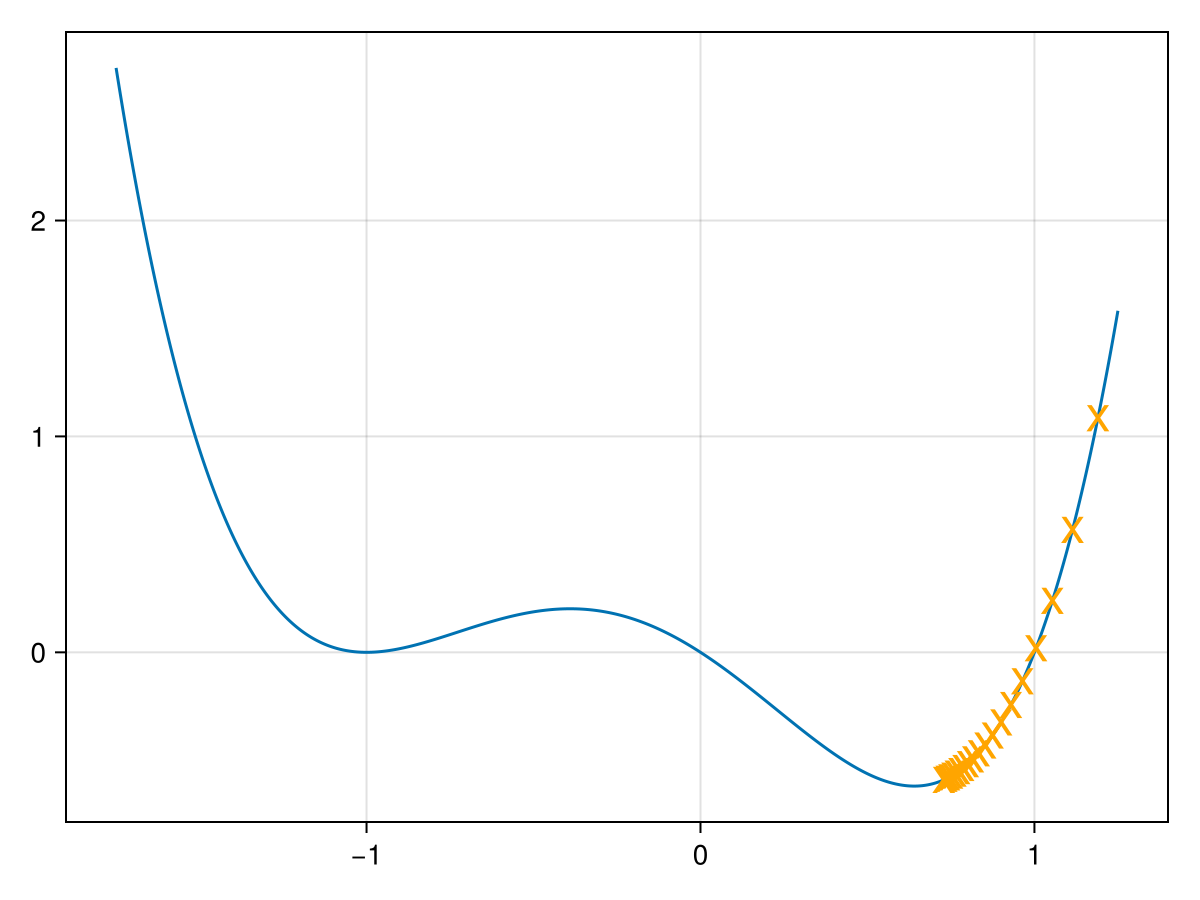

In [66]:
xᵢ₊₁ = gradient_descent_step(xᵢ, η=0.01) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:orange, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

## Newtons Method

Now we're using a local quadratic approximation, for a nearby guess $x_k$ the value of $J(\bm{x})$ can be well-approximated as

$$ J(\bm{x}) \approx J(\bm{x}_k) + \nabla J(\bm{x})^T (\bm{x} - \bm{x}_k) + \frac{1}{2} (\bm{x} - \bm{x}_k)^T \nabla^2 J(\bm{x}_k) (\bm{x} - \bm{x}_k)$$

And we can solve for our necessary condition

$$
\begin{align}
\bm{0} & \overset{\mathrm{!}}{=} \nabla J(\bm{x} + \Delta \bm{x}) \approx \nabla J(\bm{x}) + \nabla^2 J(\bm{x}) \Delta \bm{x} \\
\Delta \bm{x} & \overset{\mathrm{!}}{=} - \left(\nabla^2 J(\bm{x}) \right)^{-1} \nabla J(\bm{x}) \\ 
\end{align} 
$$

In [75]:
function ∇²h(x)
    return 12.0*x.^2 + 6.0*x - 2.0
end

∇²h (generic function with 1 method)

In [90]:
# xᵢ = x₀
xᵢ = 0.0
newton_step(xᵢ) = xᵢ - ∇²h(xᵢ)\∇h(xᵢ)

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))


Lines{Tuple{Vector{Point{2, Float64}}}}

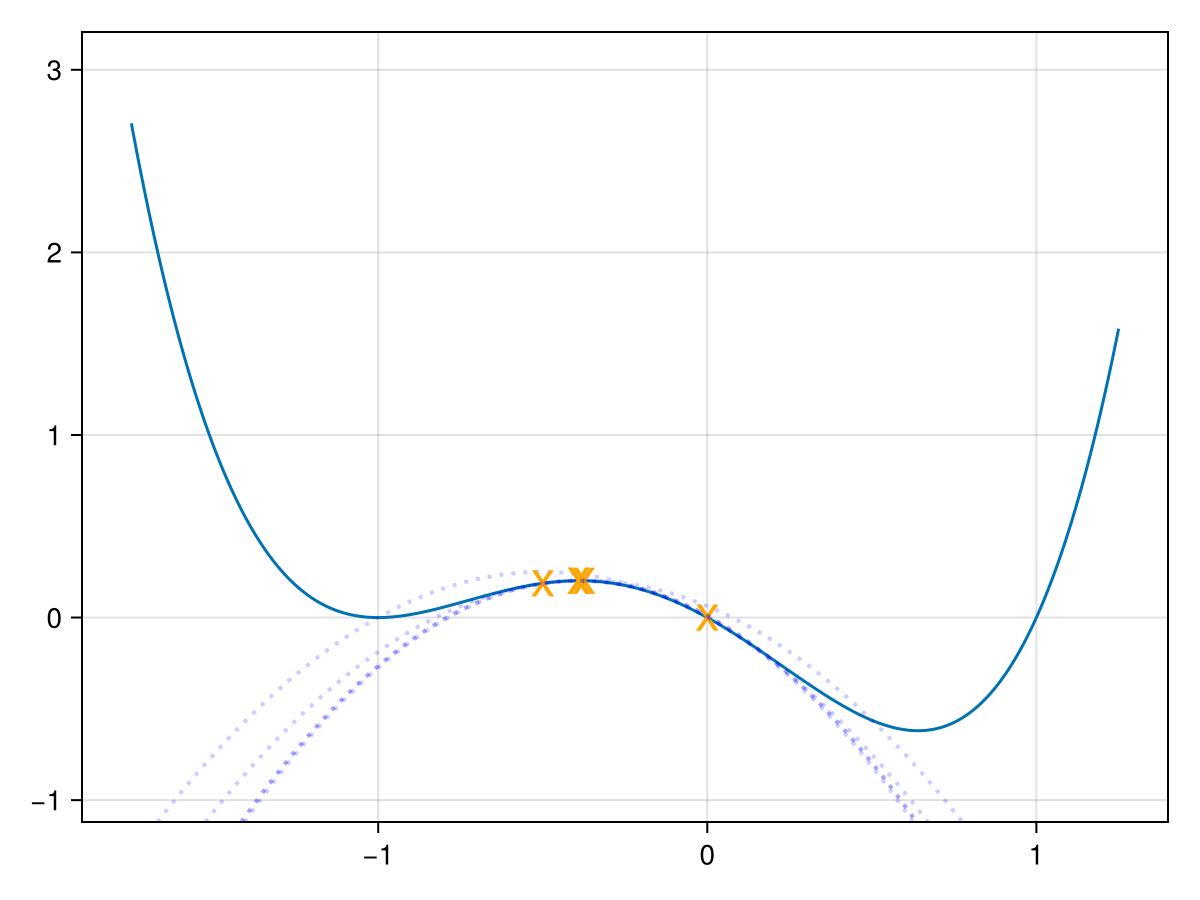

In [95]:
xᵢ₊₁ = newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:orange, marker='x', markersize=25)

# plot the quadratic approximation of the function at xᵢ as a dotted line, 
# notice how the newton step moves to the argmin of the quadratic approximation

h_q(x, xᵢ) = h(xᵢ) .+ ∇h(xᵢ) * (x .- xᵢ) .+ 0.5 * ∇²h(xᵢ) * (x .- xᵢ).^2
y_min = minimum(h(x))
y_max = maximum(h(x))
ylims!(ax1, y_min - 0.5, y_max + 0.5)
lines!(ax1, x, h_q(x, xᵢ), color=:blue, linestyle=:dot, linewidth=2, alpha=0.2)

xᵢ = xᵢ₊₁
fig1

In [ ]:
Quick check, what happened?

## Add Regularization

In the last example, our initialization violated our assumption of a positive semi-definite hessian

$$ \nabla^2 h(0) = -2 $$

The first trick we can employ is regularization. The intuition is that we want to retain second order approximation of the function for better convergence, but the approximation must ensure that the direction of travel is still one of guarenteed descent.

Check out some of [these visualizations](https://kenndanielso.github.io/mlrefined/blog_posts/7_Second_order_methods/7_4_Newtons_regularized.html) for some of the details and play around with the regularization parameter.

As mentioned on that page, solving for the regularization parameter is impractical: guess and check approximations to this value can be sufficient and are easily computable.

In [104]:
using LinearAlgebra

β = 1.0
# β = 2.75

function regularized_newton_step(xᵢ; β=β)
    H = ∇²h(xᵢ)
    while !isposdef(H) # don't do this in your own code!
        H = H + β*I
    end
    return xᵢ - H\∇h(xᵢ)
end

## Initial guess
# xᵢ = 1.19
xᵢ = 0.0

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

Lines{Tuple{Vector{Point{2, Float64}}}}

H: 7.087107377647918


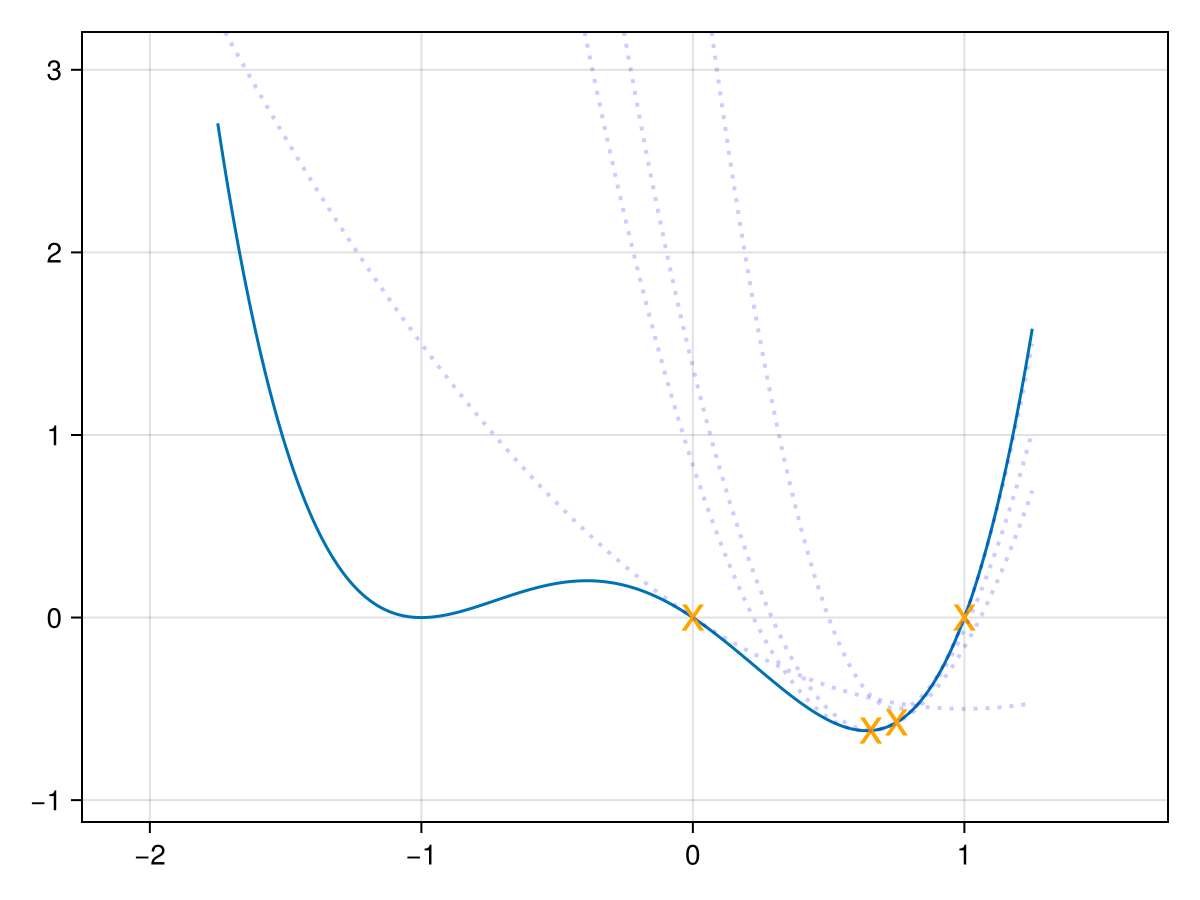

In [108]:
xᵢ₊₁ = regularized_newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:orange, marker='x', markersize=25)

# plot the quadratic approximation of the function at xᵢ as a dotted line with a regularized hessian,
function h_regularized_q(x, xᵢ)
    H = ∇²h(xᵢ)
    while !isposdef(H) # don't do this in your own code!
        H = H + β*I
    end
    println("H: ", H)
    return h(xᵢ) .+ ∇h(xᵢ) * (x .- xᵢ) .+ 0.5 * H * (x .- xᵢ).^2
end

ylims!(ax1, y_min - 0.5, y_max + 0.5)
xlims!(ax1, minimum(x) - 0.5, maximum(x) + 0.5)
lines!(ax1, x, h_regularized_q(x, xᵢ), color=:blue, linestyle=:dot, linewidth=2, alpha=0.2)

xᵢ = xᵢ₊₁
fig1

### How can this go wrong?

We for our regularization, we chose $\Beta = 1.0$ which worked well, but adding $\Beta * \bm{I}$ to our hessian until it is positive semi-definite could be bad. If the hessian has large negative eigenvalues, it can take a *REALLY* long time - linear in the magnitude of the smallest eigenvalue.

In practice, we use additional information to choose a good $\Beta$, maybe guessing and checking a few times, and then regularize the quadratic - ideally in just a few guesses and checks.

If we change the regularization parameter to something too high, this will have convergence no better than gradient descent. If it was too low (but the hessian was still positive semi-definite) we also observed overshoot.

**Final note:** regularization like this helps make the problem 'convex' in a way - another benefit to reap is that near flat areas, regularization can help ensure that the hessian does not become ill-conditioned.


In [112]:
function h(x)
    return 0.125 * x.^4 + sin.(3 * x) .+ 0.5  * x
end

function ∇h(x)
    return 0.5 * x.^3 + 3 * cos.(3 * x) .+ 0.5
end

function ∇²h(x)
    return 1.5 * x.^2 - 9 * sin.(3 * x)
end

x = range(-3.75,3.25,1000)

## Initial guess
x₀ = 0.0

0.0

In [113]:
xᵢ = x₀

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))


Lines{Tuple{Vector{Point{2, Float64}}}}

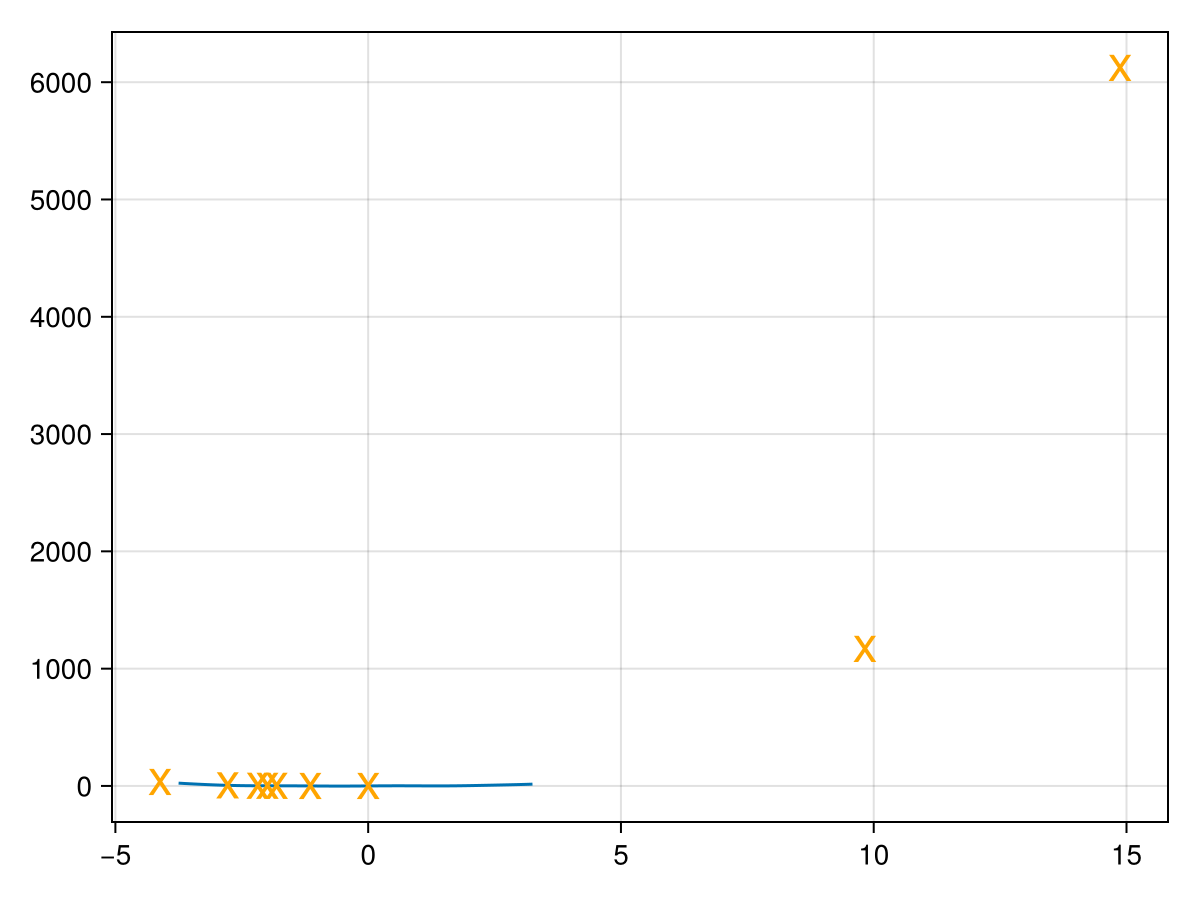

In [122]:
xᵢ₊₁ = regularized_newton_step(xᵢ; β=0.85)
plot!(ax1, [xᵢ], [h(xᵢ)], color=:orange, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

## Add line search

Ok so that was bad, things went sideways and we were all over the place. This function was tailored to diverge with $\Beta = 0.85$. We want to make sure when we are taking a step, that the slope is not changing too quickly over the step. We want to take a step that sufficiently decreases the objective

In [59]:
function backtracking_regularized_newton_step(xᵢ)
    H = ∇²h(xᵢ)

    ## regularization
    β = 1.0
    while !isposdef(H)
        H = H + β*I
    end
    Δx = -H\∇h(xᵢ)

    ## line search
    b = 0.1
    c = 0.25
    α = 1.0
    while h(xᵢ + α*Δx) > h(xᵢ) + b*α*∇h(xᵢ)*Δx
        α = c*α
    end
    
    return xᵢ + α*Δx
end

## Initial guess
# xᵢ = 1.19
xᵢ = 0.0

## Initial plot
fig1 = Figure()
ax1 = Axis(fig1[1,1])
lines!(ax1, x, h(x))

Lines{Tuple{Vector{Point{2, Float64}}}}

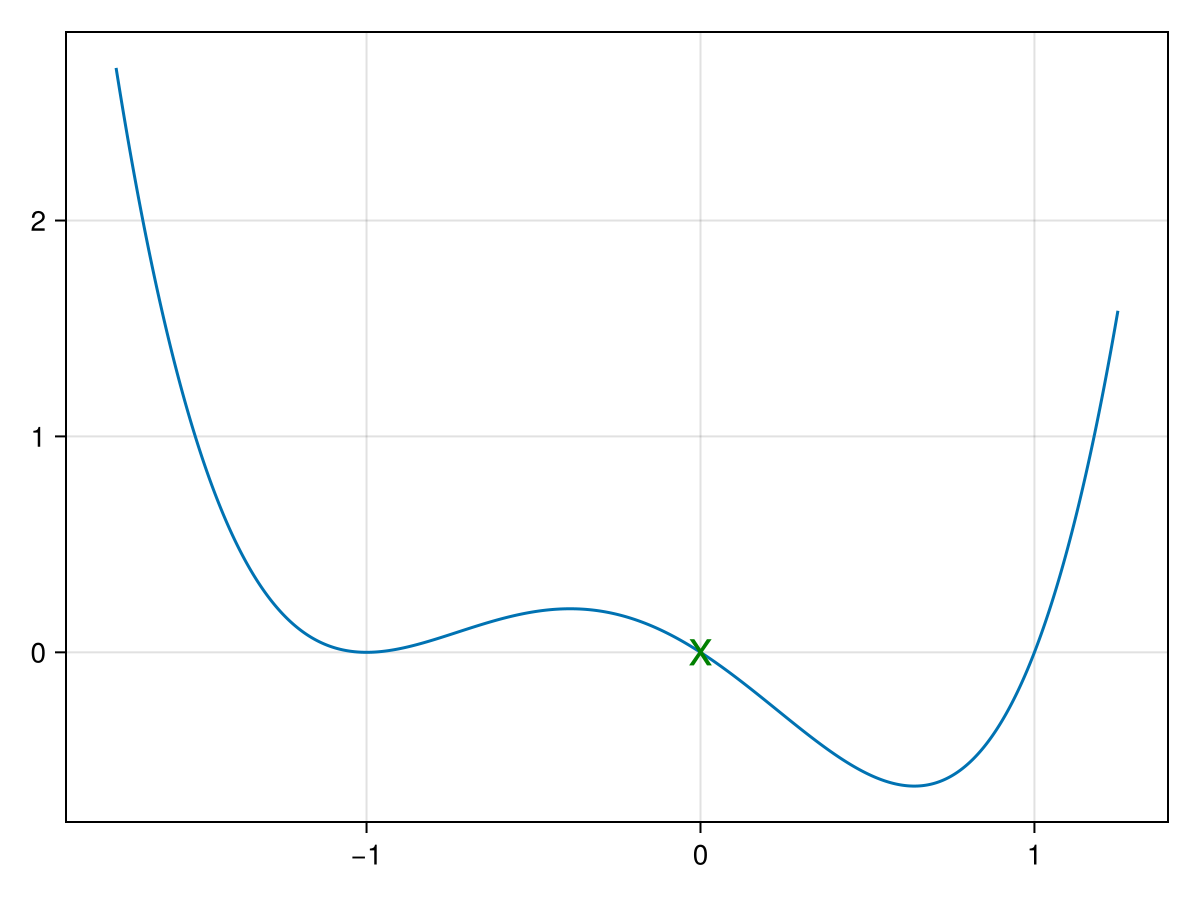

In [11]:
xᵢ₊₁ = backtracking_regularized_newton_step(xᵢ) 
plot!(ax1, [xᵢ], [h(xᵢ)], color=:green, marker='x', markersize=25)
xᵢ = xᵢ₊₁
fig1

# II. Constrained Optimization

In this section, we are going to learn about *constrained optimization*. Let's keep things simple, and start without all of the regularization and line search stuff. 

In the next cells, we'll define a 2D bowl as our cost function, and we'll draw some nice level curves to visualize it--it's a convex cost, so we know it will have a minimum at the bottom of the bowl. To make it interesting, we will add a single constraint, which we draw as a curve.

$$
J(x, y) = \frac{1}{2} \left( \tfrac{1}{2} (x - 1)^2 + (y - 1)^2 \right)
$$

# TODO - fix link
When constructing out system, to get to a minimum while respecting the contraints, we are using lagrange multipliers ([remember those?](https://youtube.com/THREE-BLUE-ONE-BROWN-VIDEO-ON-LAGRANGE-MULTIPLIERS)). At each optimization step, we will 

In [12]:
Q = Diagonal([0.5; 1])

## Objective
function J(x)
    return 1 / 2 * (x - [1; 0])' * Q * (x - [1; 0])
end

function ∇J(x)
    return Q * (x - [1; 0])
end

function ∇²J(x)
    return Q
end

## Linear constraint -- you can try this, also.
# A = [1.0 -1.0]
# b = -1.0
# function f(x)
#     return A * x - b
# end

# function ∂f(x)
#     return A
# end

## Nonlinear constraint
function f(x)
    return x[1]^2 + 2*x[1] - x[2]
end

function ∂f(x)
    return [2*x[1]+2 -1]
end

∂f (generic function with 1 method)

In [13]:
function draw_contour(ax; samples=40, levels=25)
    cols = kron(ones(samples), range(-4, 4, samples)')
    rows = kron(ones(samples)', range(-4, 4, samples))
    vals = zeros(samples,samples)
    for j = 1:samples
        for k = 1:samples
            vals[j, k] = J([cols[j, k]; rows[j, k]])
        end
    end
    contour!(ax, vec(cols), vec(rows), vec(vals), levels=levels)

    ## Linear x - y + 1 = 0 -- uncomment this if you want to try linear constraint
    # constraint = range(-4, 3, samples)
    # lines!(ax, constraint, constraint .+ 1, color=:black, linewidth=2)

    ## Nonlinear x^2 + 2x - y = 0
    constraint = range(-3.2, 1.2, samples)
    lines!(ax, constraint, constraint.^2 .+ 2*constraint, color=:black, linewidth=2)
end

draw_contour (generic function with 1 method)

In [14]:
using ForwardDiff

function newton_step(xᵢ, λᵢ)
    ∂²L_∂x² = ∇²J(xᵢ) + ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)
    ∂f_∂x = ∂f(xᵢ)

    ## KKT system
    H = [∂²L_∂x² ∂f_∂x'; ∂f_∂x 0]
    g = [∇J(xᵢ) + ∂f_∂x'λᵢ; f(xᵢ)]
    
    Δz = -H\g
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return xᵢ .+ Δx, λᵢ .+ Δλ
end

newton_step (generic function with 2 methods)

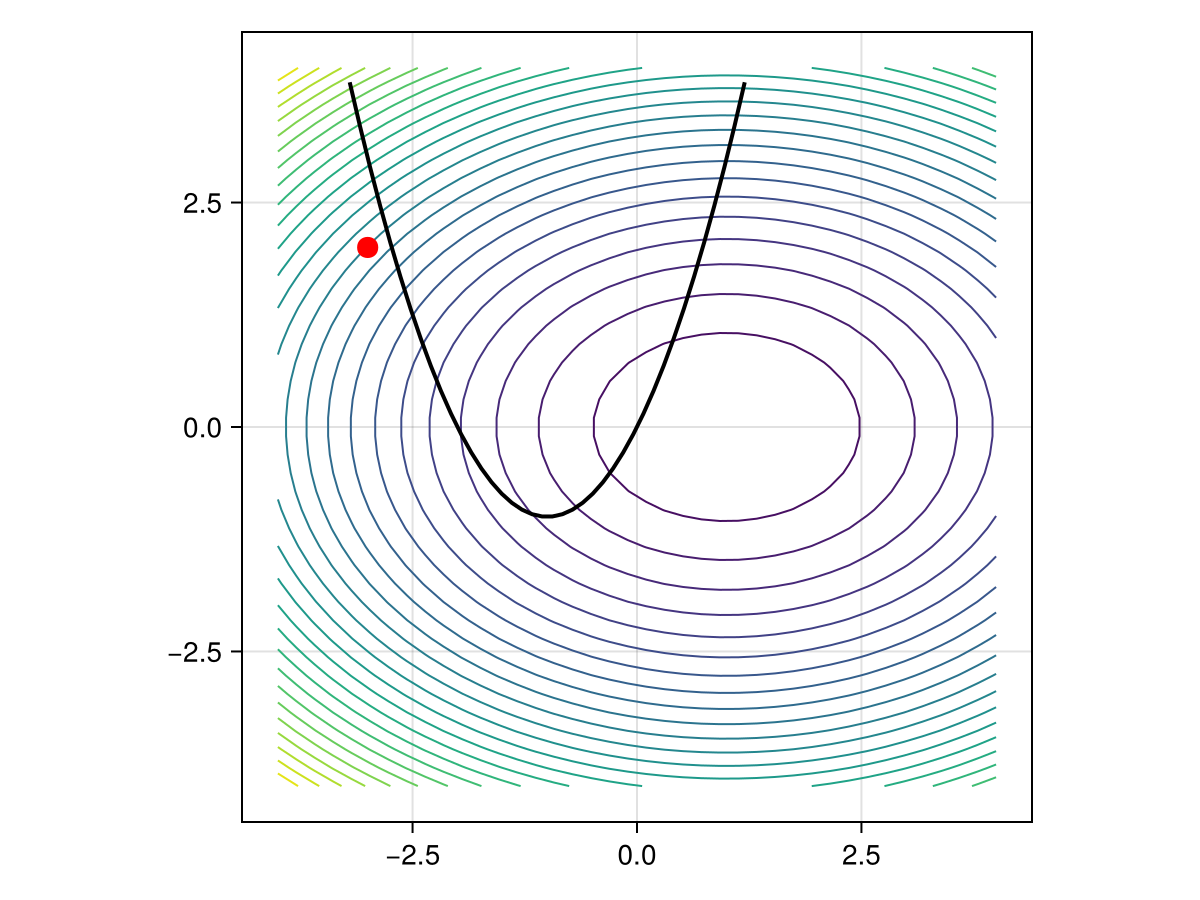

In [15]:
fig = Figure()
ax = Axis(fig[1,1], aspect=1)

## Initial guess
# xᵢ = Float64[-0.75; -1.75]
xᵢ = Float64[-3; 2]
λᵢ = Float64[0.0]

## Draw the initial contours and the initial guess
draw_contour(ax)
plot!(ax, [xᵢ[1]], [xᵢ[2]], color=:red, marker=:circle, markersize=15)
fig

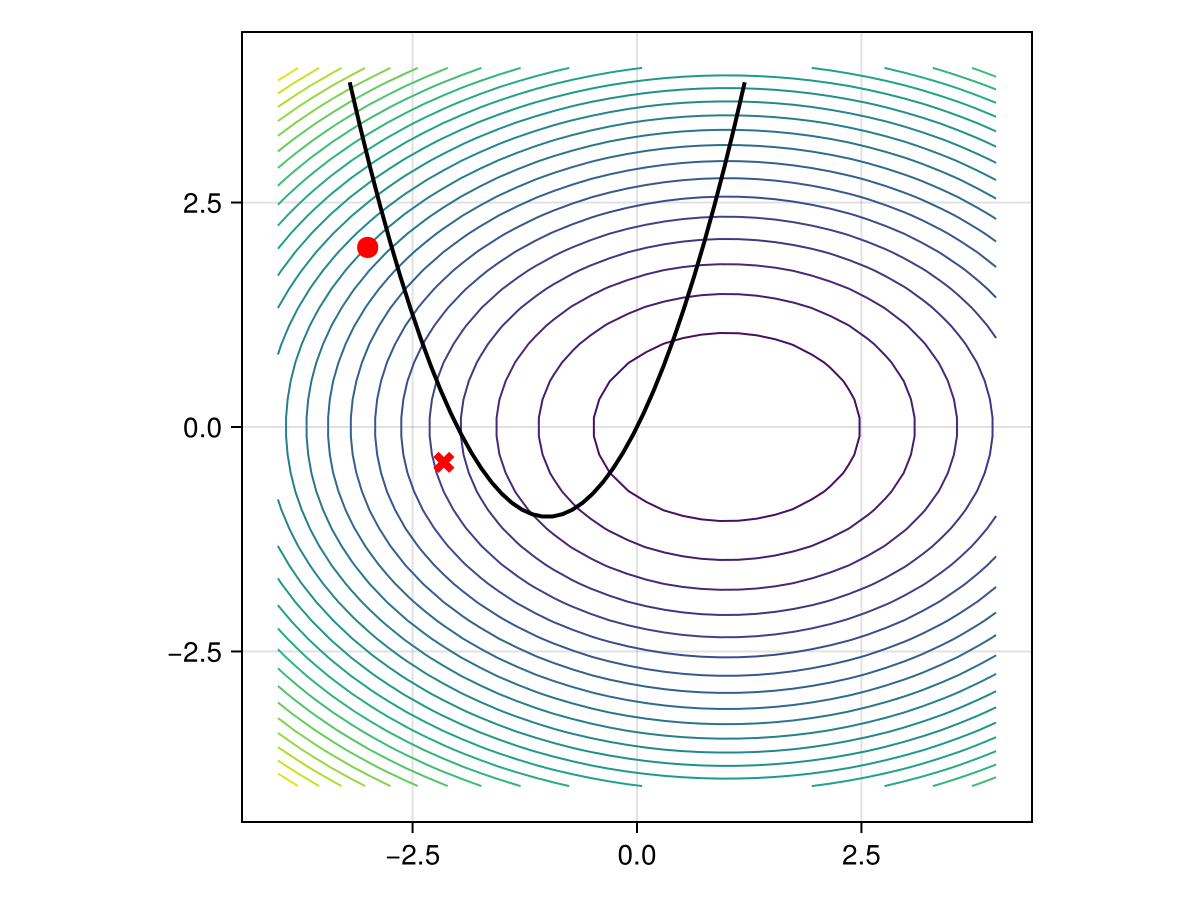

In [16]:
xᵢ₊₁, λᵢ₊₁ = newton_step(xᵢ, λᵢ)
plot!(ax, [xᵢ₊₁[1]], [xᵢ₊₁[2]], color=:red, marker=:x, markersize=15)
xᵢ .= xᵢ₊₁
λᵢ .= λᵢ₊₁

fig

In [17]:
## Inspect the Hessian
H = ∇²J(xᵢ) + ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)

2×2 Matrix{Float64}:
 -0.287879  0.0
  0.0       1.0

We need regularization... even though we picked a convex cost! The constraint in our system makes this problem not convex anymore. Let's add regularization, but we will do so a bit differently.

# TODO remove this first sentence
Recall from Part I, where we learned about LBFGS approximation to Newton's method, and how the LBFGS seemed to have robustness properites that Newton's method lacked. We will make a similar approximation to our KKT system, called the *Gauss-Newton approximation*. See the exercises below for a more detailed explanation.

The thought process is as follows: After inspecting `∂²L_∂x² = ∇²J(xᵢ) + ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)`, we note that $\nabla^2 J$ is convex by construction. It is just the `ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)` that causes trouble with the Hessian. At this time, we also notice that latter term is also expensive to compute. Because it causes trouble and is costly to compute, we decide to drop this term. This is the Gauss-Newton approximation. Its steps compute faster, but converge slower than Newton--luckily, the savings in compute speed often overtake any reduction in convergence rate!

In [18]:
function gauss_newton_step(xᵢ, λᵢ)
    ## Implicit regularization
    ∂²L_∂x² = ∇²J(xᵢ) #+ ForwardDiff.jacobian(x -> ∂f(x)'λᵢ, xᵢ)
    ∂f_∂x = ∂f(xᵢ)

    ## KKT system
    H = [∂²L_∂x² ∂f_∂x'; ∂f_∂x 0]
    g = [∇J(xᵢ) + ∂f_∂x'λᵢ; f(xᵢ)]
    
    Δz = -H\g
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return xᵢ .+ Δx, λᵢ .+ Δλ
end

gauss_newton_step (generic function with 1 method)

This quick calculation should hopefully remind you about the Gauss-Newton approximation.

Start with a cost $J(\mathbf{x})$. The necessary condition for optimality is $\nabla J(\mathbf{x}) = 0$. Our journey starts by asking what happens if $J(\mathbf{x})$ is actually a least squares problem. For example, $J(\mathbf{x}) := \frac{1}{2}||\mathbf{g}(\mathbf{x})||_2^2$. 

\begin{equation}
    \nabla J(\mathbf{x}) = \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \mathbf{g}(\mathbf{x})
\end{equation}

\begin{equation}
    \nabla^2 J(\mathbf{x}) = \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}} + \nabla(\frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T}) \mathbf{g}(\mathbf{x}) \approx \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}
\end{equation}

\begin{equation}
    \Delta \mathbf{x} = - \left(\frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}\right)^{-1}
    \frac{\partial \mathbf{g}(\mathbf{x})}{\partial \mathbf{x}}^\text{T} \mathbf{g}(\mathbf{x})
\end{equation}

In [ ]:
fig = Figure()
ax = Axis(fig[1,1], aspect=1)

## Initial guess
# xᵢ = Float64[-0.75; -1.75]
xᵢ = Float64[-3; 2]
λᵢ = Float64[0.0]

x2ᵢ, λ2ᵢ = xᵢ, λ2ᵢ

draw_contour(ax)
plot!(ax, [xᵢ[1]], [xᵢ[2]], color=:green, marker=:circle, markersize=15)
# plot!(ax, [xᵢ[1]], [xᵢ[2]], color=:red, marker=:circle, markersize=15)

Scatter{Tuple{Vector{Point{2, Float64}}}}

In [ ]:
# x2ᵢ₊₁, λ2ᵢ₊₁ = newton_step(x2ᵢ, λ2ᵢ)
xᵢ₊₁, λᵢ₊₁ = gauss_newton_step(xᵢ, λᵢ)
plot!(ax, [xᵢ₊₁[1]], [xᵢ₊₁[2]], color=:green, marker=:x, markersize=15)
# plot!(ax, [x2ᵢ₊₁[1]], [x2ᵢ₊₁[2]], color=:red, marker=:x, markersize=15)
xᵢ .= xᵢ₊₁
λᵢ .= λᵢ₊₁
# x2ᵢ .= x2ᵢ₊₁
# λ2ᵢ .= λ2ᵢ₊₁

fig